In [1]:
import pandas as pd
import numpy as np

In [2]:
# git clone https://github.com/bstabler/TransportationNetworks.git
# copy the Sioux Falls folder to the current directory

_prefix = "./SiouxFalls/SiouxFalls"

node_df = pd.read_csv(f"{_prefix}_node.csv")
net_df = pd.read_csv(f"{_prefix}_net.csv")
od_df = pd.read_csv(f"{_prefix}_od.csv")

print(f"Numer of nodes: {len(node_df)}")
print(f"Numer of edges: {len(net_df)}")
print(f"Numer of OD pairs: {len(od_df)}")

Numer of nodes: 24
Numer of edges: 76
Numer of OD pairs: 528


## Simplify the problem

### Option 1: Remove nodes

comment the next cell to keep all nodes

In [3]:
nodes_to_ignore = [0, 1, 2, 6, 11, 12, 17] # 0-indexed
_nodes_to_ignore = [node + 1 for node in nodes_to_ignore] # 1-indexed

all_ = list(range(len(node_df))) # 0-indexed
nodes_to_keep = list(set(all_) - set(nodes_to_ignore)) # 0-indexed
_nodes_to_keep = [node + 1 for node in nodes_to_keep] # 1-indexed
mapping = {node: int(i + 1) for i, node in enumerate(_nodes_to_keep)} # 1-indexed

# remove the nodes from the node_df
node_df = node_df[~node_df["Node"].isin(_nodes_to_ignore)]
# reindex the Node column
node_df = node_df.reset_index(drop=True)
node_df["Node"] = np.arange(len(node_df)) + 1

# remove the nodes from the net_df
net_df = net_df[~net_df["A"].isin(_nodes_to_ignore)]
net_df = net_df[~net_df["B"].isin(_nodes_to_ignore)]
# reindex the A and B columns using the mapping
net_df["A"] = net_df["A"].map(mapping)
net_df["B"] = net_df["B"].map(mapping)
# reindex the LINK column
net_df = net_df.reset_index(drop=True)
net_df["LINK"] = np.arange(len(net_df))

# remove the nodes from the od_df
od_df = od_df[~od_df["O"].isin(_nodes_to_ignore)]
od_df = od_df[~od_df["D"].isin(_nodes_to_ignore)]
# reindex the A and B columns using the mapping
od_df["O"] = od_df["O"].map(mapping)
od_df["D"] = od_df["D"].map(mapping)
# reindex the O and D columns
od_df = od_df.reset_index(drop=True)

### Option 2: Remove trips

comment the next cell to keep all trips

In [4]:
# randomly select OD pairs in the od_df
od_df = od_df.sample(n=30, random_state=42)

In [5]:
topology = {}

topology['graph'] = {'directed': True,
                    'type': "list",
                    'nodes': [], 
                    'edges': []}

# nodes
for index, row in node_df.iterrows():
    id = int(row["Node"]) - 1
    position_x = int(row["X"])
    position_y = int(row["Y"])
    _x = {'id': id, 'position_x': position_x, 'position_y': position_y}
    topology['graph']['nodes'].append(_x)

# edges
for index, row in net_df.iterrows():
    id = int(row["LINK"])
    source = int(row["A"]) - 1
    target = int(row["B"]) - 1
    r = {'id': id, 'source': source, 'target': target, 'distance': 1}
    topology['graph']['edges'].append(r)

# segments
topology['segments'] = {"type": "list", 
                        "list": []}

capacity = 100
travel_time = 1

for index, row in net_df.iterrows():
    source = int(row["A"]) - 1
    target = int(row["B"]) - 1
    s = {'source': source, 'target': target, 'travel_time': travel_time, 'capacity': capacity, 'position_x': None, 'position_y': None}
    topology['segments']['list'].append(s)

In [6]:
# traffic 
trips = {"list": [], "type": "list"}

for index, row in od_df.iterrows():
    origin = int(row["O"]) - 1
    destination = int(row["D"]) - 1
    volume = int(row["Ton"]) / 25
    
    t = {'origin': origin, 'destination': destination, 'volume': volume}
    trips['list'].append(t)

In [7]:
# write to YAML
import yaml

# load a YAML file
with open("../presets/ToyExample-v2/ToyExample-v2.yaml", 'r') as file:
    toy_example_config = yaml.load(file, Loader=yaml.FullLoader)

# update the topology
toy_example_config['topology'] = topology
toy_example_config['traffic']['trips'] = trips

with open("../presets/SiouxFalls-v1/SiouxFalls-v1.yaml", 'w') as file:
    yaml.dump(toy_example_config, file, indent=2)

In [8]:
import numpy as np

from imp_act import make

env = make("SiouxFalls-v1")

Number of nodes: 17
Number of edges: 52


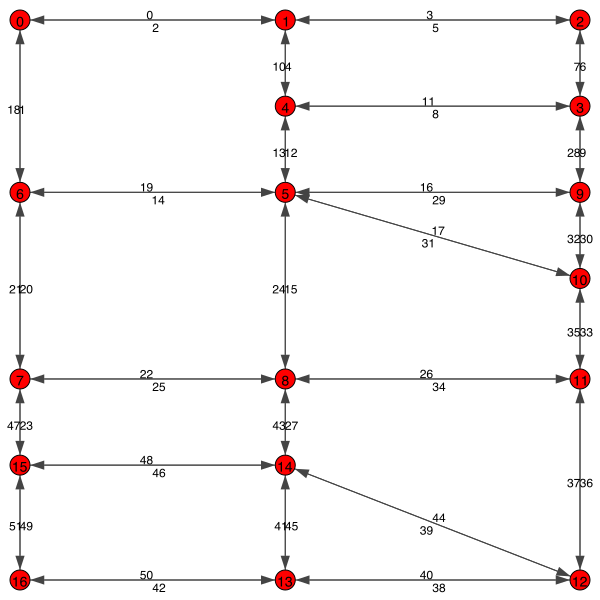

In [9]:
import igraph as ig
import matplotlib.pyplot as plt

# Assuming g is your igraph graph
g = env.graph

# Specify node locations
node_positions = [(v['position_x'], -v['position_y']) for v in g.vs]

num_nodes = len(g.vs)
num_edges = len(g.es)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

# Plot the graph using igraph
layout = ig.Layout(node_positions)
g.es["curved"] = False
ig.plot(g, layout=layout, vertex_label=g.vs["id"], edge_label=g.es["id"])

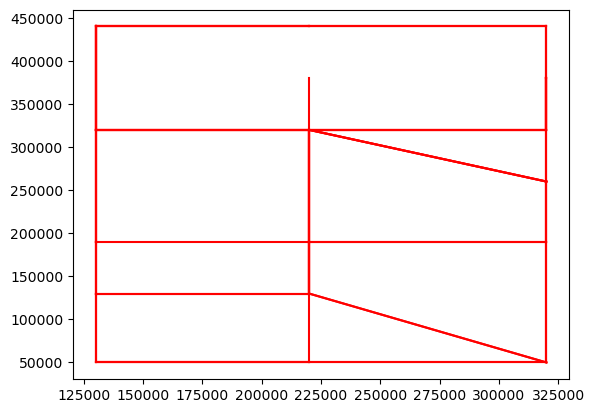

In [10]:
# get shortest paths for each OD pair
shortest_paths = []
for index, row in od_df.iterrows():
    source = int(row["O"]) - 1
    target = int(row["D"]) - 1
    path = g.get_shortest_paths(source, to=target, weights=g.es["distance"], mode="OUT", output="vpath")
    shortest_paths.append(path)

# plot the shortest paths
for path in shortest_paths:
    for i in range(len(path[0]) - 1):
        source = path[0][i]
        target = path[0][i+1]
        x = [g.vs[source]['position_x'], g.vs[target]['position_x']]
        y = [g.vs[source]['position_y'], g.vs[target]['position_y']]
        plt.plot(x, y, 'r-')

In [11]:
print(env.get_count_redundancies_summary())

Summary | Network Trips

Total number of trips: 30

O: 15, D: 1 | # paths: 240
O: 5, D: 7 | # paths: 89
O: 0, D: 5 | # paths: 97
O: 0, D: 8 | # paths: 183
O: 5, D: 12 | # paths: 140
O: 11, D: 8 | # paths: 90
O: 2, D: 13 | # paths: 334
O: 15, D: 2 | # paths: 303
O: 16, D: 9 | # paths: 267
O: 8, D: 15 | # paths: 123
O: 8, D: 11 | # paths: 90
O: 14, D: 16 | # paths: 120
O: 4, D: 14 | # paths: 239
O: 3, D: 5 | # paths: 96
O: 6, D: 10 | # paths: 95
O: 3, D: 12 | # paths: 228
O: 3, D: 14 | # paths: 210
O: 3, D: 9 | # paths: 139
O: 10, D: 6 | # paths: 95
O: 14, D: 3 | # paths: 210
O: 15, D: 13 | # paths: 114
O: 12, D: 16 | # paths: 134
O: 16, D: 2 | # paths: 386
O: 12, D: 2 | # paths: 295
O: 10, D: 11 | # paths: 181
O: 10, D: 0 | # paths: 139
O: 7, D: 1 | # paths: 192
O: 8, D: 12 | # paths: 126
O: 15, D: 6 | # paths: 200
O: 9, D: 1 | # paths: 112

Summary | Network Redundancy

1 trips have 96 redundancies
1 trips have 182 redundancies
1 trips have 333 redundancies
1 trips have 95 redundancies

In [12]:
print(env.get_edge_traffic_summary())

Summary | Edge Traffic

Edge    Volume (%)    Travel Time
------------------------------
  0    16  (16.0%)      1.00      
  1    69  (69.5%)      1.03      
  2     1  (1.5%)      1.00      
  3     8  (8.0%)      1.00      
  4     1  (1.7%)      1.00      
  5    13  (13.9%)      1.00      
  6     0  (0.8%)      1.00      
  7    22  (22.8%)      1.00      
  8    73  (73.6%)      1.04      
  9    136 (136.2%)      1.52      
 10     9  (9.2%)      1.00      
 11    15  (15.9%)      1.00      
 12    102 (102.3%)      1.16      
 13    24  (24.2%)      1.00      
 14    124 (124.3%)      1.36      
 15    132 (132.7%)      1.47      
 16     9  (10.0%)      1.00      
 17    85  (85.5%)      1.08      
 18    36  (36.0%)      1.00      
 19    92  (92.1%)      1.11      
 20    81  (81.7%)      1.07      
 21    68  (68.0%)      1.03      
 22    15  (15.9%)      1.00      
 23    38  (38.4%)      1.00      
 24    23  (23.9%)      1.00      
 25    56  (56.6%)      1.02      
 2

In [13]:
from imp_act import make, Recorder, RolloutPlotter

In [14]:
recorded_env = Recorder(env)

# record rollouts
for ep in range(10):

    obs = recorded_env.reset()
    done = False
    while not done:

        actions = [[0] * len(e["road_edge"].segments) for e in env.graph.es]

        obs, reward, done, info = recorded_env.step(actions)

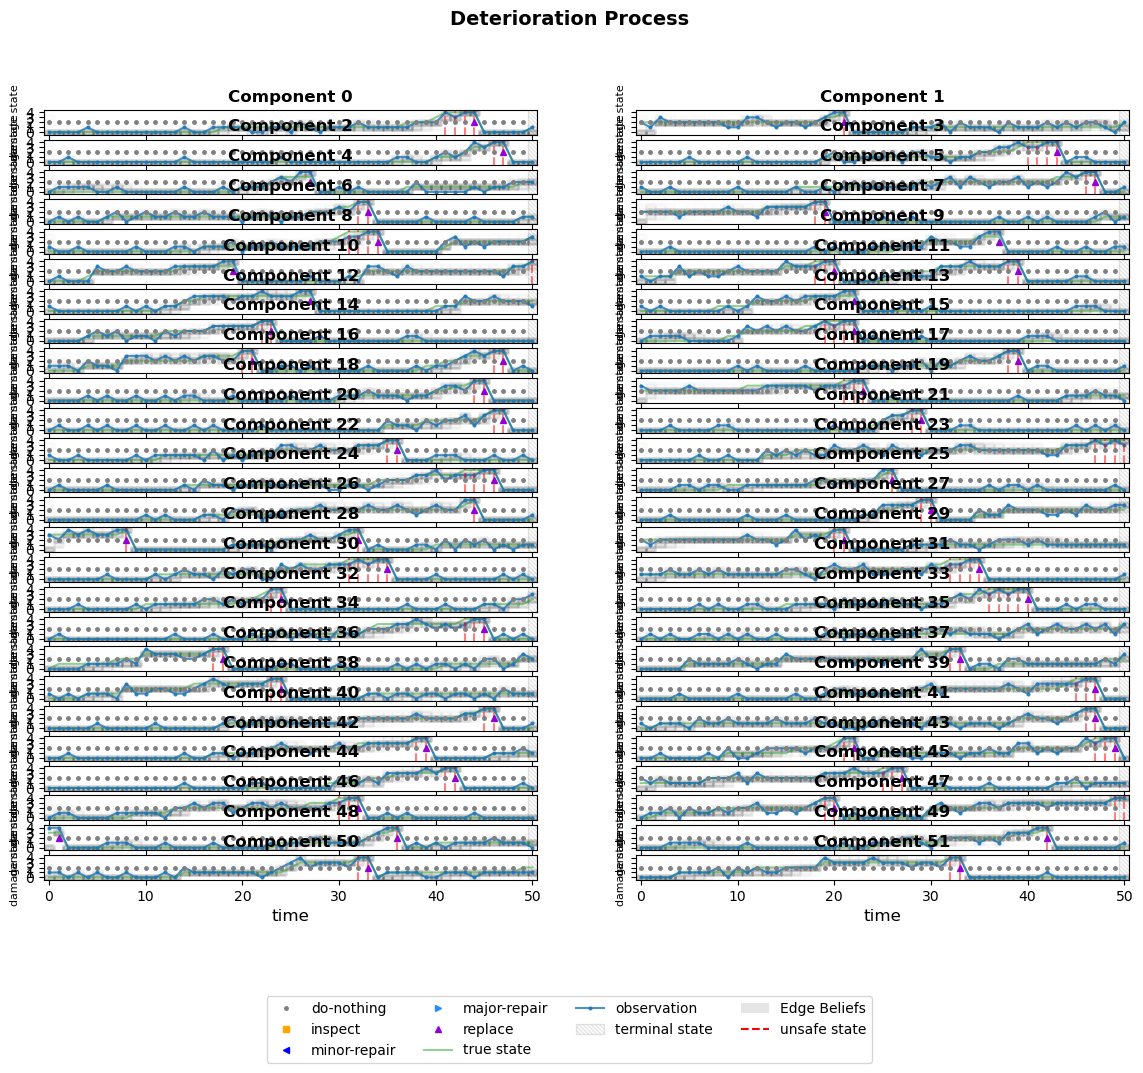

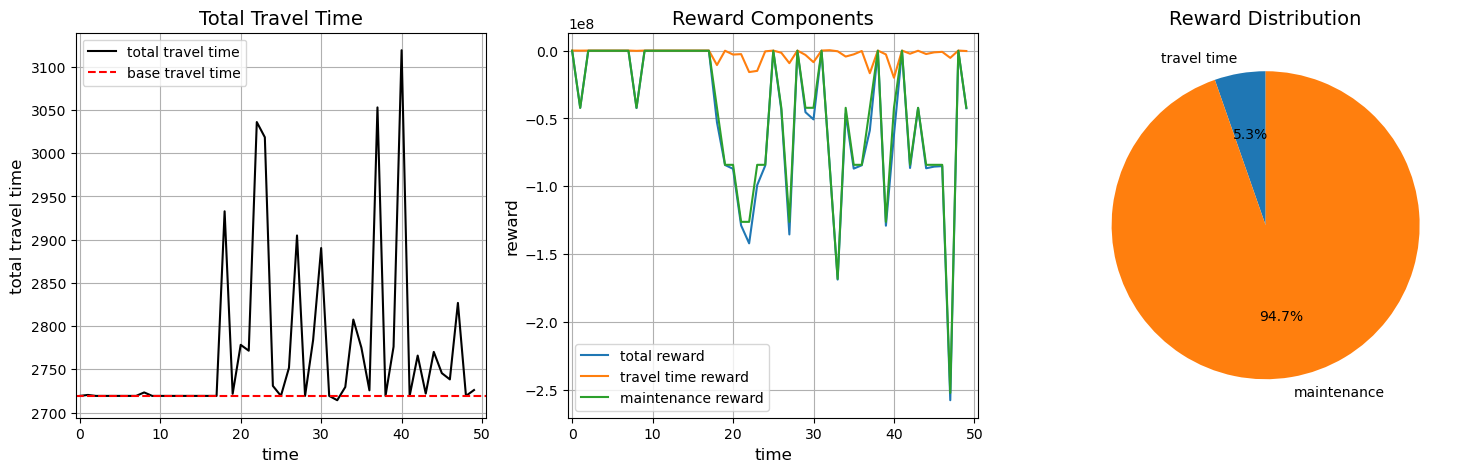

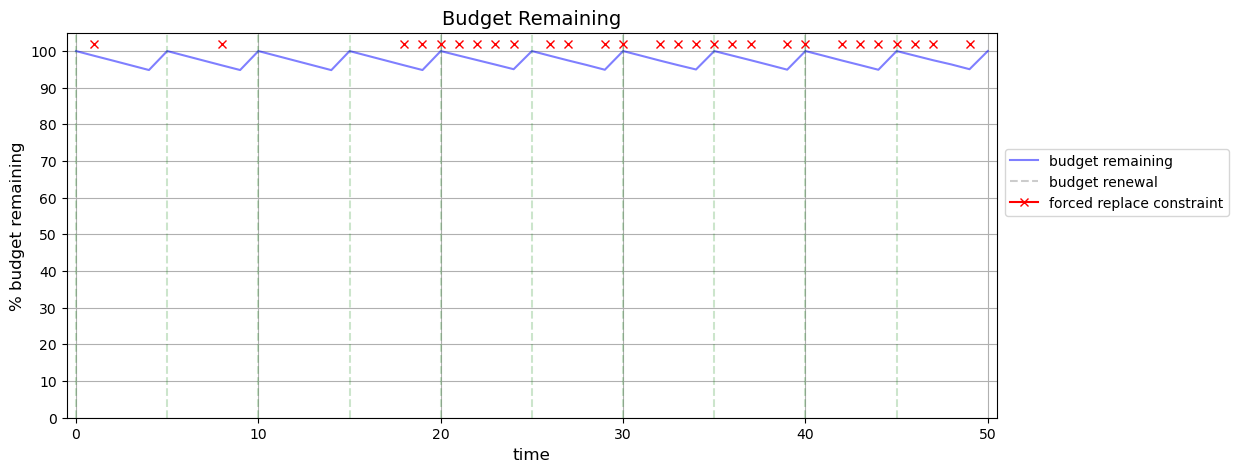

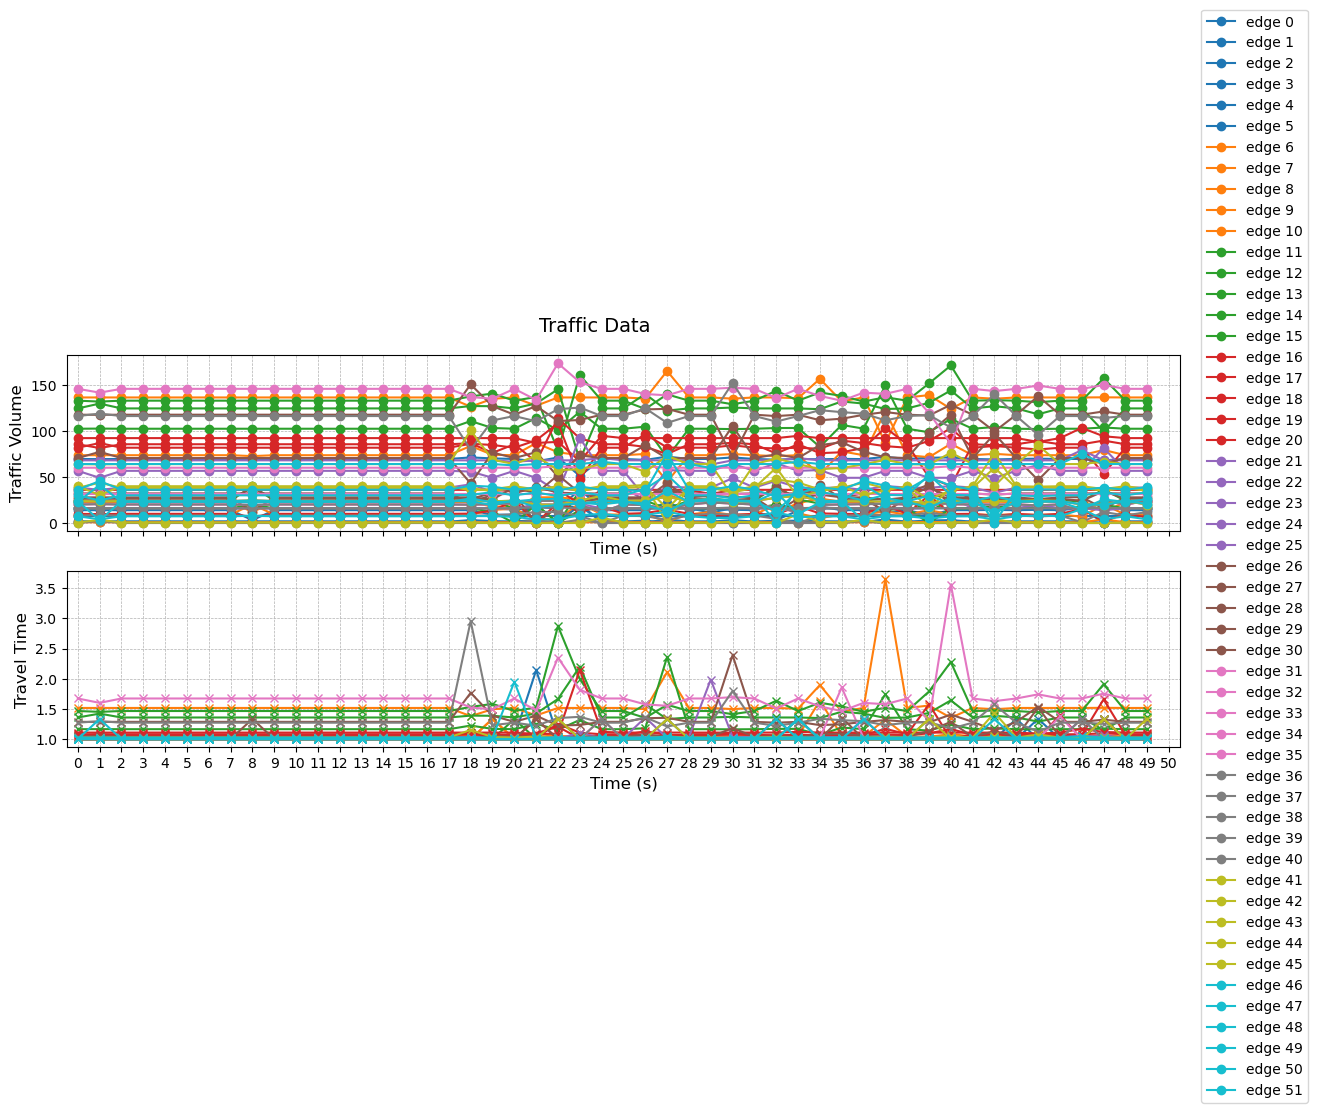

In [16]:
rollout_data = recorded_env.rollout_data

plotter = RolloutPlotter(env)

ep = 2 # episode to plot
plotter.plot(episode_data=rollout_data[ep])